In [22]:
import torch
print(torch.__version__)

import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics YOLOv8.2.42  Python-3.12.3 torch-2.3.1+cpu CPU (Intel Core(TM) i5-8250U 1.60GHz)
Setup complete  (8 CPUs, 7.9 GB RAM, 112.8/118.0 GB disk)


In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import glob
import shutil
import torchvision

from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from shutil import copyfile
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw, ImageFont
from PIL import __version__ as pil_version
from ultralytics import *
from scipy.ndimage import gaussian_filter1d

%matplotlib inline

In [24]:
TRAIN_PATH = "C:\\srujan_global_project\\train"
TEST_PATH = 'C:\\srujan_global_project\\test/'
IMG_SIZE = 1024
BATCH_SIZE = 16
EPOCHS = 100

In [25]:
%cd ../

df = pd.read_csv('C:\\srujan_global_project\\train.csv')
df['path'] = df.apply(lambda row: TRAIN_PATH+row.image_id+'.jpg', axis=1)
df.head()

C:\


c:\Users\Lenoo\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


image_id  width  height                         bbox   source  \
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1   
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1   
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1   
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1   
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1   

                                          path  
0  C:\srujan_global_project\trainb6ab77fd7.jpg  
1  C:\srujan_global_project\trainb6ab77fd7.jpg  
2  C:\srujan_global_project\trainb6ab77fd7.jpg  
3  C:\srujan_global_project\trainb6ab77fd7.jpg  
4  C:\srujan_global_project\trainb6ab77fd7.jpg

In [26]:
def display_images(df):
    # set up the canvas for the subplots
    plt.figure(figsize=(30,30))
    j = 1
    for i in range(0,900,100):
        # Load an image
        image = plt.imread(df.path[i])
        
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        plt.subplot(3,3,j)
        j+=1
        plt.imshow(image)
        plt.axis('off')

In [27]:
train_list, valid_list = train_test_split(df.image_id.unique(), test_size=0.2, random_state=1)

In [28]:
len(train_list)

2698

In [29]:
len(valid_list)

675

In [30]:
train_df = df.loc[df.image_id.isin(train_list)]
valid_df = df.loc[df.image_id.isin(valid_list)]

train_df.loc[:, 'split'] = 'train'
valid_df.loc[:, 'split'] = 'valid'

df = pd.concat([train_df, valid_df]).reset_index(drop=True)

C:\Users\Lenoo\AppData\Local\Temp\ipykernel_12772\4127551595.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'split'] = 'train'
C:\Users\Lenoo\AppData\Local\Temp\ipykernel_12772\4127551595.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df.loc[:, 'split'] = 'valid'


In [31]:
len(train_df), len(valid_df)

(117750, 30043)

In [32]:
df

image_id  width  height                         bbox     source  \
0       b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]    usask_1   
1       b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]    usask_1   
2       b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]    usask_1   
3       b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]    usask_1   
4       b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]    usask_1   
...           ...    ...     ...                          ...        ...   
147788  a5c8d5f5c   1024    1024   [473.0, 637.0, 62.0, 67.0]  arvalis_2   
147789  a5c8d5f5c   1024    1024   [980.0, 207.0, 44.0, 84.0]  arvalis_2   
147790  a5c8d5f5c   1024    1024  [568.0, 348.0, 123.0, 94.0]  arvalis_2   
147791  a5c8d5f5c   1024    1024    [10.0, 806.0, 64.0, 92.0]  arvalis_2   
147792  a5c8d5f5c   1024    1024  [788.0, 199.0, 164.0, 74.0]  arvalis_2   

                                               path  split  
0       C:\srujan_global_project\trainb6ab77fd7.jpg  train  
1       C:\srujan_global_project\trainb6ab77fd7.jpg  train  
2       C:\srujan_global_project\trainb6ab77fd7.jpg  train  
3       C:\srujan_global_project\trainb6ab77fd7.jpg  train  
4       C:\srujan_global_project\trainb6ab77fd7.jpg  train  
...                                             ...    ...  
147788  C:\srujan_global_project\traina5c8d5f5c.jpg  valid  
147789  C:\srujan_global_project\traina5c8d5f5c.jpg  valid  
147790  C:\srujan_global_project\traina5c8d5f5c.jpg  valid  
147791  C:\srujan_global_project\traina5c8d5f5c.jpg  valid  
147792  C:\srujan_global_project\traina5c8d5f5c.jpg  valid  

[147793 rows x 7 columns]

In [33]:
print(f'Size of dataset: {len(df)}, training images: {len(train_df)}. validation images: {len(valid_df)}')

Size of dataset: 147793, training images: 117750. validation images: 30043


In [34]:
%cd ../../
%cd "C:\\srujan_global_project"

os.makedirs('dataset/images/train', exist_ok=True)
os.makedirs('dataset/images/valid', exist_ok=True)
os.makedirs('dataset/images/test', exist_ok=True)

os.makedirs('dataset/labels/train', exist_ok=True)
os.makedirs('dataset/labels/valid', exist_ok=True)
os.makedirs('dataset/labels/test', exist_ok=True)

%cd ../../
!tree "C:\\srujan_global_project//dataset"

C:\
C:\srujan_global_project
C:\


c:\Users\Lenoo\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Folder PATH listing for volume Windows-SSD
Volume serial number is EC63-F686
C:\SRUJAN_GLOBAL_PROJECT\DATASET
+---images
�   +---test
�   +---train
�   +---valid
+---labels
    +---test
    +---train
    +---valid


In [35]:
df['path'] = df.apply(lambda row: TRAIN_PATH + '\\' + row.image_id + '.jpg', axis=1)

for i in range(len(df)):
    row = df.loc[i]
    if os.path.exists(row.path):
        if row.split == 'train':
            copyfile(row.path, f'C:\\srujan_global_project\\dataset\\images\\train/{row.image_id}.jpg')
        else:
            copyfile(row.path, f'C:\\srujan_global_project\\dataset\\images\\valid{row.image_id}.jpg')
    else:
        print(f"File not found: {row.path}")

In [38]:
import os
import shutil

# Source and target paths
src = 'C:\\srujan_global_project\\test'  # Path to your test images
trg = 'C:\\srujan_global_project\\dataset\\images\\test'  # Destination directory for test images

# Create target directory if it doesn't exist
os.makedirs(trg, exist_ok=True)

# Get a list of all files in the source directory
files = os.listdir(src)

# Iterate over all the files in the source directory
for fname in files:
    # Form the full file path for the source
    src_file_path = os.path.join(src, fname)
    # Copying the files to the destination directory
    shutil.copy2(src_file_path, trg)


In [39]:
# Navigate to the working directory
%cd "C:\\srujan_global_project"

C:\srujan_global_project


In [40]:
%%writefile dataset.yaml
path: C:\\srujan_global_project\\dataset  # Base path to your dataset
train: images/train  # Relative path to training images
val: images/valid    # Relative path to validation images
test: images/test    # Relative path to test images

# Classes
names:
    0: none
    1: opacity

Writing dataset.yaml


In [43]:
# Open the dataset.yaml file and print its contents
with open('dataset.yaml', 'r') as file:
    contents = file.read()
    print(contents)

path: C:\\srujan_global_project\\dataset  # Base path to your dataset
train: images/train  # Relative path to training images
val: images/valid    # Relative path to validation images
test: images/test    # Relative path to test images

# Classes
names:
    0: none
    1: opacity



In [44]:
def get_bbox(row):
    bboxes = []
    bbox = []
    list1 = row.bbox.replace("[", "").replace("]","").replace(",","")
    for i in list1.split(" "):
        bboxes.append(float(i))
    return bboxes

In [45]:
# Convert the bounding boxes in YOLO format.
def get_yolo_format_bbox(img_w, img_h, bboxes):
    yolo_boxes = []
    x = bboxes[0]
    y = bboxes[1]
    w = bboxes[2] 
    h = bboxes[3] 
    xc = x + int(w/2) # xmin + width/2
    yc = y + int(h/2) # ymin + height/2
    yolo_boxes=[1, xc/img_w, yc/img_h, w/img_w, h/img_h] # x_center y_center width height
    yolo_boxes = str(yolo_boxes).replace("[", "").replace("]","").replace(",","")
    return yolo_boxes

In [46]:
# Prepare the txt files for bounding box
for i in tqdm(range(len(df))):
    row = df.loc[i]
    # Get image id
    img_id = row.image_id
    # Get split
    split = row.split
    
    if row.split=='train':
        file_name = f'dataset/labels/train/{row.image_id}.txt'
    else:
        file_name = f'dataset/labels/valid/{row.image_id}.txt'
        
    bboxes = get_bbox(row)
        
    # Format for YOLOv5
    yolo_bboxes = get_yolo_format_bbox(IMG_SIZE, IMG_SIZE, bboxes)
        
    with open(file_name, 'a') as f:
        f.write(yolo_bboxes)
        f.write('\n')
    #print(file_name)
    #print(yolo_bboxes)

100%|██████████| 147793/147793 [03:11<00:00, 770.08it/s] 


In [47]:
TRAIN_PATH = 'dataset/images/train'
TRAIN_LABEL_PATH = 'dataset/labels/train'

In [48]:
train_files = os.listdir(TRAIN_LABEL_PATH)
print('Number of test images predicted as opaque: ', len(train_files))

Number of test images predicted as opaque:  2698


In [49]:
def display_images_with_box(num):
    pred = []
    bbox = []
    image_id = []
    k = 1
    plt.figure(figsize=(30,30))
    for i in train_files[:num]:
        with open(f'{TRAIN_LABEL_PATH}/{i}') as f:
            img = read_image(f'{TRAIN_PATH}/{i[:-4]}.jpg')
            bbox = []
            for j in f:
                pred = i[:-4] + " " + j[:-1]
                pred = pred.split(" ")
                pred.pop(0)
                pred.pop(0)
                pred = [eval(i) for i in pred]
                pred = [i*1024 for i in pred]
                [x, y, w, h] = pred
                [xmin, ymin, xmax, ymax] = [x-w/2, y-h/2, x+w/2, y+h/2,]
                pred = [xmin, ymin, xmax, ymax]
                bbox.append(pred)
            bbox = torch.tensor(bbox, dtype=torch.int)
            img = draw_bounding_boxes(img, bbox, width=10,colors=(255,0,0))
            img = torchvision.transforms.ToPILImage()(img)
            plt.subplot(num//3+num%3,3,k)
            k+=1
            plt.imshow(img)
            plt.axis('off')

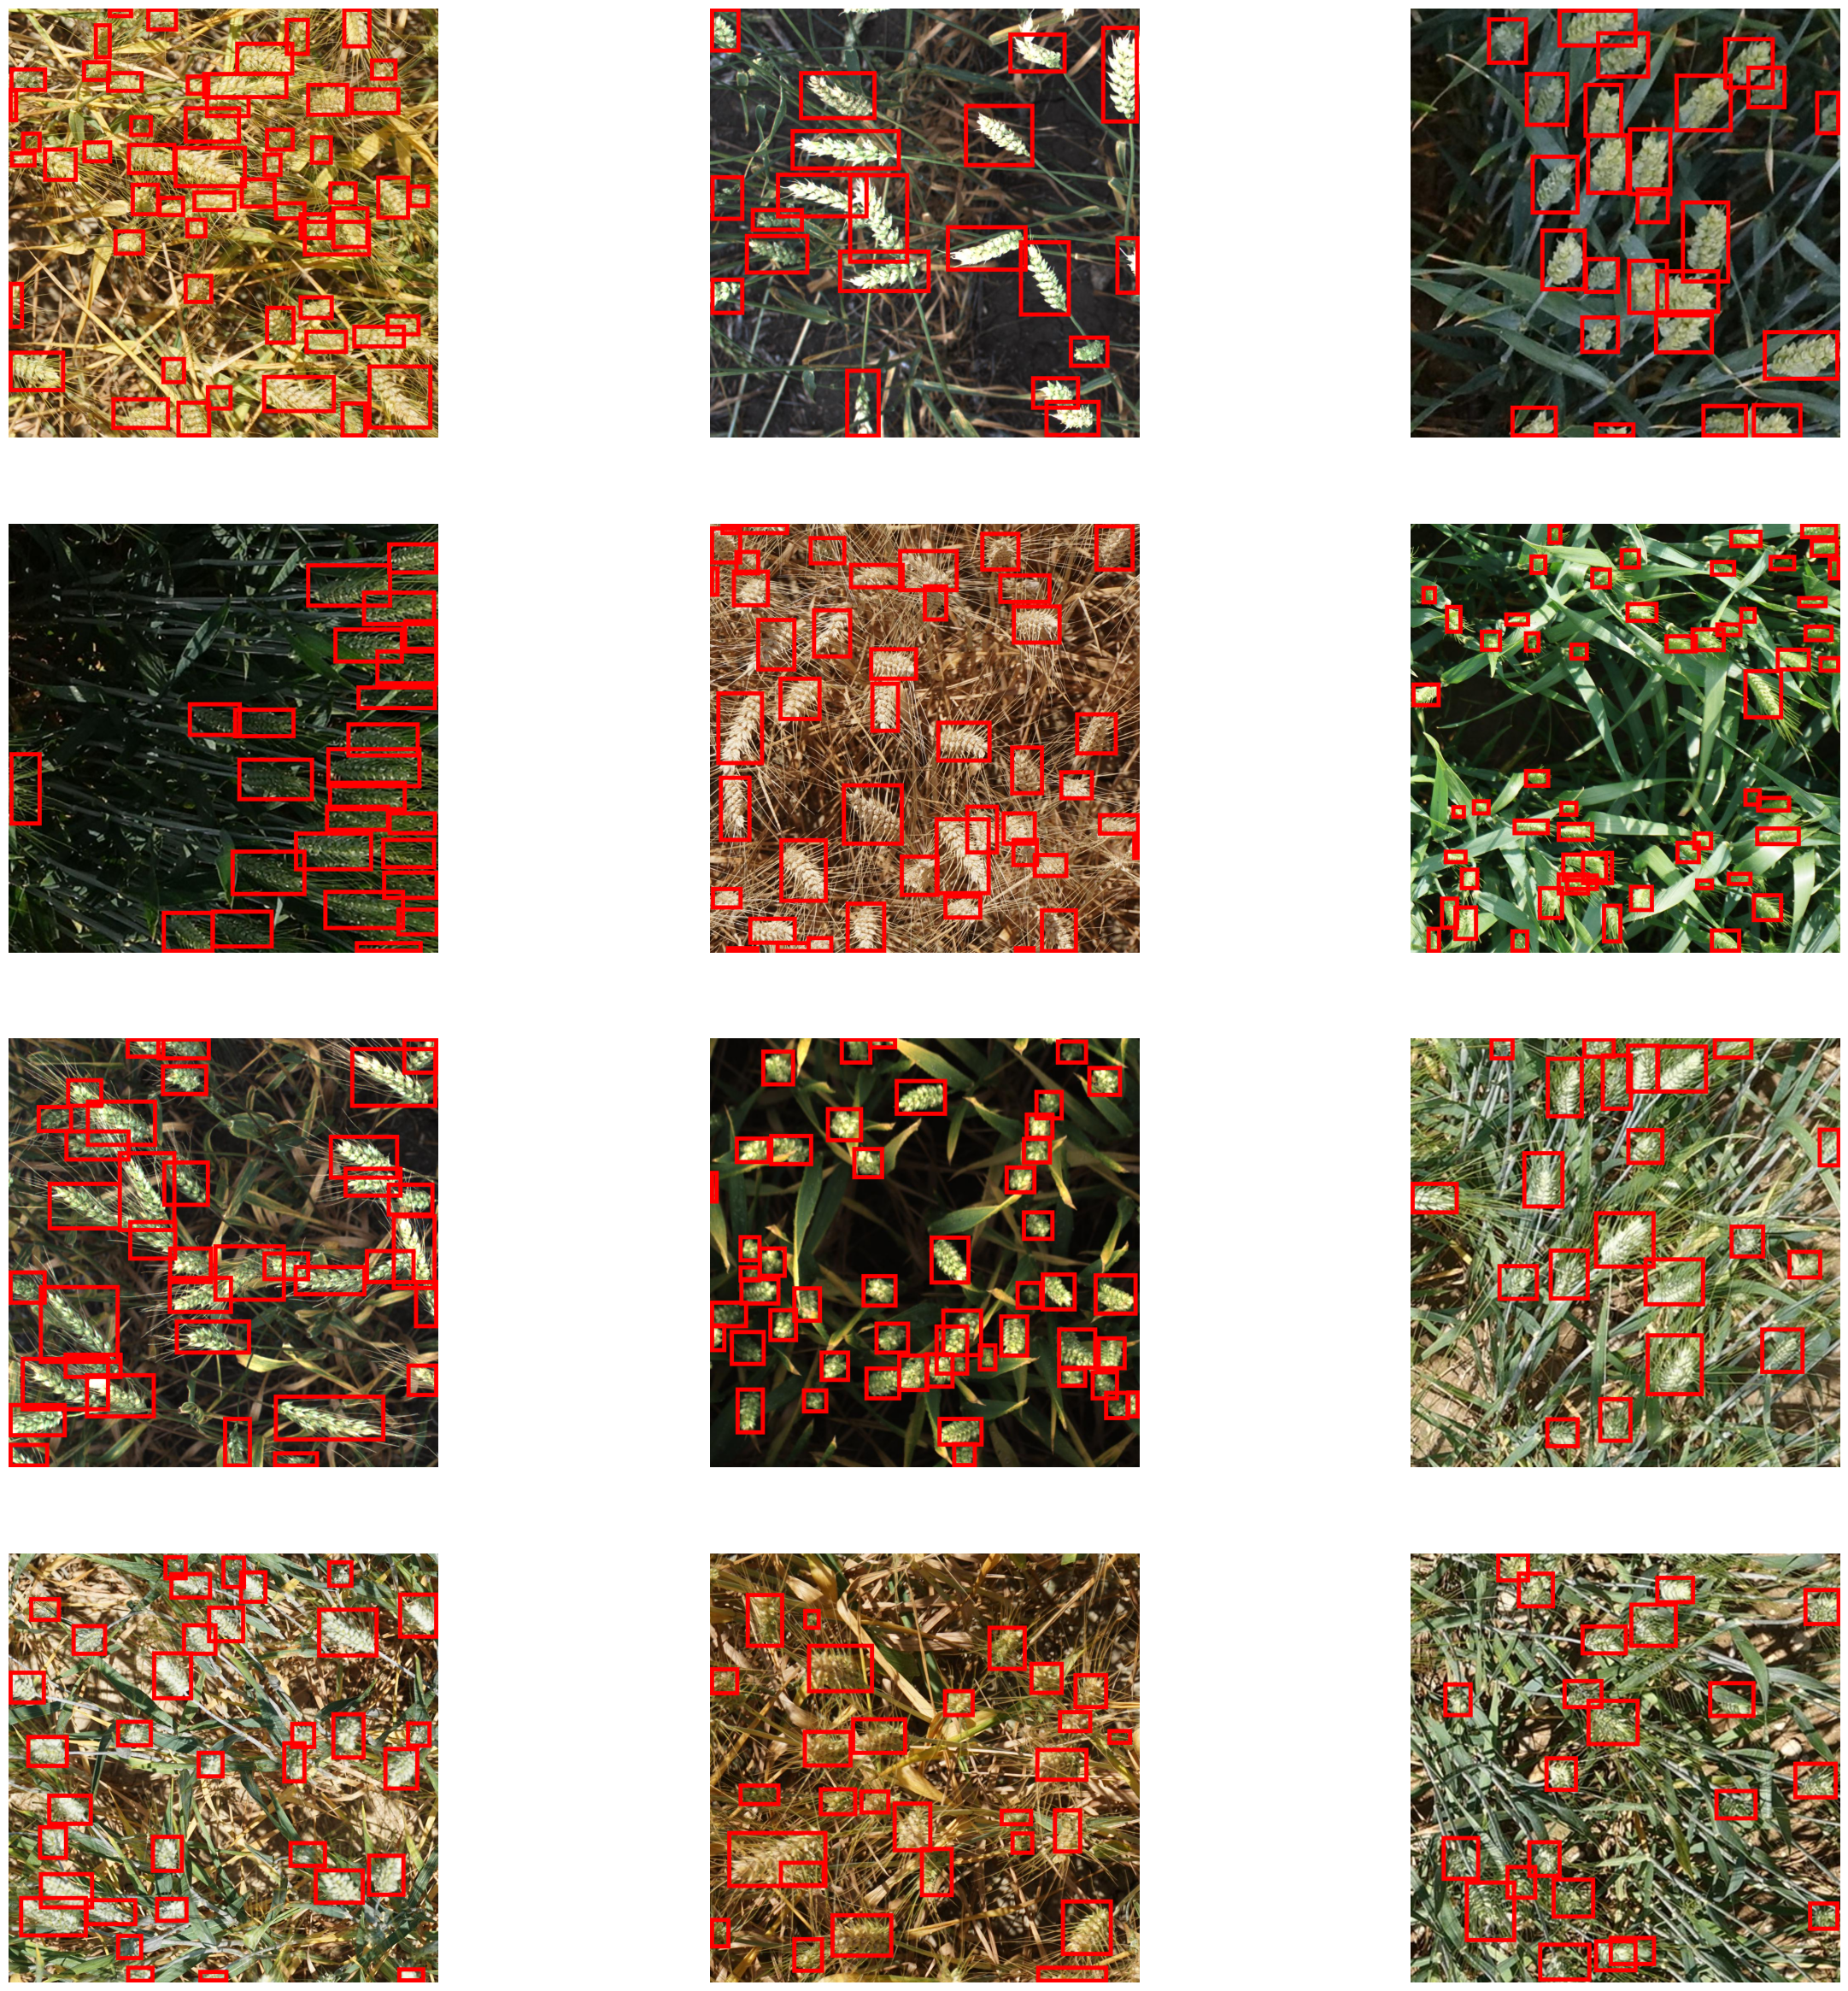

In [50]:
display_images_with_box(12)

In [51]:
# Change directory to the project root
%cd "C:\\srujan_global_project"

# Change directory to the working directory
%cd "C:\\srujan_global_project\\dataset"

C:\srujan_global_project
C:\srujan_global_project\dataset


In [52]:
model = YOLO("yolov8n.yaml")  # build a new model from scratch
model = YOLO("../input/roi-mammography416-yolov8/ROI Mammography 416/yolov8n.pt")

100%|██████████| 6.25M/6.25M [00:36<00:00, 178kB/s] 


In [2]:
!wandb off
model.train(data='C:\\srujan_global_project\\dataset.yaml', epochs=EPOCHS, imgsz=IMG_SIZE, batch=BATCH_SIZE, save_period=1, cls=7)

W&B offline. Running your script from this directory will only write metadata locally. Use wandb disabled to completely turn off W&B.


NameError: name 'model' is not defined

In [63]:
import os
from shutil import copyfile
from tqdm import tqdm

# Paths
src_dir = 'C:\\srujan_global_project\\train'  # Source directory with images
train_dir = 'C:\\srujan_global_project\\dataset\\images\\train'
valid_dir = 'C:\\srujan_global_project\\dataset\\images\\valid'

# Ensure target directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)

# Copy images
for i in tqdm(range(len(df))):
    row = df.loc[i]
    img_id = row.image_id
    split = row.split

    if split == 'train':
        src_path = row.path
        trg_path = os.path.join(train_dir, f'{img_id}.jpg')
    elif split == 'valid':
        src_path = row.path
        trg_path = os.path.join(valid_dir, f'{img_id}.jpg')
    else:
        continue

    if os.path.exists(src_path):
        copyfile(src_path, trg_path)
    else:
        print(f"Source file does not exist: {src_path}")


100%|██████████| 147793/147793 [04:57<00:00, 496.23it/s]


In [7]:
from ultralytics import YOLO

# Download and use the YOLOv8n (nano) model
model = YOLO('yolov8n.pt')  # This will download the model automatically

100%|██████████| 6.25M/6.25M [00:01<00:00, 3.46MB/s]


In [1]:
from ultralytics import YOLO

# Initialize YOLO model with default settings
model = YOLO()  # Initializes a model with default weights

# Define training parameters
EPOCHS = 100
IMG_SIZE = 1024
BATCH_SIZE = 16

# Start training
model.train(data='C:\\srujan_global_project\\dataset.yaml', epochs=EPOCHS, imgsz=IMG_SIZE, batch=BATCH_SIZE, save_period=1, cls=7)

KeyboardInterrupt: 

In [4]:
import numpy as np
import pandas as pd

# Load data
data = pd.read_csv('enjoysport.csv')
concepts = np.array(data.iloc[:, :-1])
target = np.array(data.iloc[:, -1])

def learn(concepts, target):
    specific_h = concepts[0].copy()
    general_h = [["?" for _ in range(len(specific_h))] for _ in range(len(specific_h))]

    for i, h in enumerate(concepts):
        if target[i] == "yes":
            specific_h = ['?' if h[x] != specific_h[x] else specific_h[x] for x in range(len(specific_h))]
            general_h = [['?' if h[x] != specific_h[x] else general_h[x][x] for x in range(len(specific_h))] for _ in range(len(specific_h))]
        else:
            for x in range(len(specific_h)):
                if h[x] != specific_h[x]:
                    general_h[x][x] = specific_h[x]
                else:
                    general_h[x][x] = '?'

    general_h = [h for h in general_h if h != ['?' for _ in range(len(specific_h))]]
    return specific_h, general_h

# Run learning algorithm
s_final, g_final = learn(concepts, target)

# Print results
print("Final Specific_h:", s_final, sep="\n")
print("Final General_h:", g_final, sep="\n")

Final Specific_h:
['sunny', 'warm', 'high', 'strong', '?', '?']
Final General_h:
[['sunny', 'warm', '?', '?', '?', '?'], ['sunny', 'warm', '?', '?', '?', '?'], ['sunny', 'warm', '?', '?', '?', '?'], ['sunny', 'warm', '?', '?', '?', '?'], ['sunny', 'warm', '?', '?', '?', '?'], ['sunny', 'warm', '?', '?', '?', '?']]


In [5]:
import numpy as np

# Data
X = np.array([[2, 9], [1, 5], [3, 6]], dtype=float) / np.amax([[2, 9], [1, 5], [3, 6]], axis=0)
y = np.array([[92], [86], [89]], dtype=float) / 100

# Functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def derivatives_sigmoid(x):
    return x * (1 - x)

# Parameters
epoch, lr = 5000, 0.1
input_neurons, hidden_neurons, output_neurons = 2, 3, 1

# Weights and Biases
wh = np.random.uniform(size=(input_neurons, hidden_neurons))
bh = np.random.uniform(size=(1, hidden_neurons))
wout = np.random.uniform(size=(hidden_neurons, output_neurons))
bout = np.random.uniform(size=(1, output_neurons))

# Training
for _ in range(epoch):
    # Forward Propagation
    hinp = np.dot(X, wh) + bh
    hlayer_act = sigmoid(hinp)
    outinp = np.dot(hlayer_act, wout) + bout
    output = sigmoid(outinp)
    
    # Backpropagation
    d_output = (y - output) * derivatives_sigmoid(output)
    d_hiddenlayer = d_output.dot(wout.T) * derivatives_sigmoid(hlayer_act)
    
    wout += hlayer_act.T.dot(d_output) * lr
    wh += X.T.dot(d_hiddenlayer) * lr

# Results
print("Input:\n", X)
print("Actual Output:\n", y)
print("Predicted Output:\n", output)

Input:
 [[0.66666667 1.        ]
 [0.33333333 0.55555556]
 [1.         0.66666667]]
Actual Output:
 [[0.92]
 [0.86]
 [0.89]]
Predicted Output:
 [[0.89340515]
 [0.87901634]
 [0.89768417]]


In [ ]:
import numpy as np
import pandas as pd
from pgmpy.estimators import *

# Read Cleveland Heart Disease data
heart_disease_data = pd.read_csv('heart.csv').replace('?', np.nan)

# Display sample data and data types
print('Sample instances from the dataset:')
print(heart_disease_data.head())
print('\nAttributes and datatypes:')
print(heart_disease_data.dtypes)

# Create Bayesian Network model
model = BayesianModel([
    ('age', 'heartdisease'),
    ('sex', 'heartdisease'),
    ('exang', 'heartdisease'),
    ('cp', 'heartdisease'),
    ('heartdisease', 'restecg'),
    ('heartdisease', 'chol')
])

# Learn CPDs using Maximum Likelihood Estimators
print('\nLearning CPD using Maximum Likelihood Estimators')
model.fit(heart_disease_data, estimator=MaximumLikelihoodEstimator)

# Inference with Bayesian Network
print('\nInference with Bayesian Network:')
inference = VariableElimination(model)

# Probability of HeartDisease given restecg = 1
q1 = inference.query(variables=['heartdisease'], evidence={'restecg': 1})
print('\n1. Probability of HeartDisease given restecg = 1:')
print(q1)

# Probability of HeartDisease given cp = 2
q2 = inference.query(variables=['heartdisease'], evidence={'cp': 2})
print('\n2. Probability of HeartDisease given cp = 2:')
print(q2)

In [6]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Load the iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameters
kernels = ['rbf']
gammas = [0.5]
Cs = [0.01, 1, 10]

best_accuracy = 0
best_support_vectors = None

# Train SVM classifiers with different hyperparameters
for kernel in kernels:
    for gamma in gammas:
        for C in Cs:
            clf = SVC(kernel=kernel, gamma=gamma, C=C, decision_function_shape='ovr')
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            support_vectors = clf.n_support_.sum()
            print(f"Kernel: {kernel}, Gamma: {gamma}, C: {C}, Accuracy: {accuracy}, Support Vectors: {support_vectors}")
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_support_vectors = support_vectors

print("\nBest classification accuracy:", best_accuracy)
print("Total number of support vectors for best accuracy:", best_support_vectors)

Kernel: rbf, Gamma: 0.5, C: 0.01, Accuracy: 0.3, Support Vectors: 120
Kernel: rbf, Gamma: 0.5, C: 1, Accuracy: 1.0, Support Vectors: 39
Kernel: rbf, Gamma: 0.5, C: 10, Accuracy: 1.0, Support Vectors: 31

Best classification accuracy: 1.0
Total number of support vectors for best accuracy: 39


AttributeError: 'list' object has no attribute 'split'